In [1]:
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
def get_df_from_url(url):
    # Send a GET request to the API URL
    req = requests.get(url)
    
    # Ensure the request was successful (status code 200)
    if req.status_code == 200:
        wb = req.json()  # Parse the JSON response
        
        # Check if the response is directly a list of records
        if isinstance(wb, list):
            # Directly normalize the list of records into a DataFrame
            df = pd.json_normalize(wb)
        else:
            # If the response contains a 'results' key, normalize that
            df = pd.json_normalize(wb.get("results", []))
        
        return df
    else:
        # Handle failed request (non-200 status code)
        print(f"Failed to retrieve data: {req.status_code}")
        return None

Importation des donnees via l''API de Paris Open Data

In [3]:
api_url_statique = 'https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/belib-points-de-recharge-pour-vehicules-electriques-donnees-statiques/exports/json'
api_url_real_time = 'https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/belib-points-de-recharge-pour-vehicules-electriques-disponibilite-temps-reel/exports/json'
api_url_routier= 'https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/comptages-routiers-permanents/exports/json'

df_static = get_df_from_url(api_url_statique)

In [17]:
df_static.head()

,id_pdc_local,statut_pdc,arrondissement,id_station_local,id_station_itinerance,nom_station,code_insee_commune,implantation_station,nbre_pdc,date_maj,...,prise_type_2,prise_type_combo_ccs,prise_type_chademo,prise_type_autre,prise_type_3,horaires,raccordement,coordonneesxy.lon,coordonneesxy.lat,year
0,FR*V75*E9016*09*3,En service,16e Arrondissement,FR*V75*P9016*09,FRV75P901609,Paris | Rue Chardon Lagache 2,75116,Voirie,3,2024-07-01,...,True,True,True,False,True,24/7,Direct,2.268339,48.846760,2021
1,FR*V75*E9018*03*1,En service,18e Arrondissement,FR*V75*P9018*03,FRV75P901803,Paris | Rue des Poissonniers 150,75118,Voirie,3,2024-07-01,...,True,True,True,False,True,24/7,Direct,2.352758,48.897670,2021
2,FR*V75*E9020*05*3,En service,20e Arrondissement,FR*V75*P9020*05,FRV75P902005,Paris | Rue Louis Lumière 104,75120,Voirie,3,2024-07-01,...,True,True,True,False,True,24/7,Direct,2.411770,48.863766,2021
3,FR*V75*EPX16*01*6,En service,16e Arrondissement,FR*V75*PPX16*01,FRV75PPX1601,Paris | Rue Molitor 16,75116,Voirie,6,2024-07-01,...,True,False,False,False,False,24/7,Direct,2.264033,48.845284,2021
4,FR*V75*EPX02*01*1,En service,Paris centre,FR*V75*PPX02*01,FRV75PPX0201,Paris | Rue Notre-Dame des Victoires 21,75102,Voirie,4,2024-07-01,...,True,False,False,False,False,24/7,Direct,2.342325,48.869698,2021


In [27]:
df_static.columns

Index(['id_pdc_local', 'statut_pdc', 'arrondissement', 'id_station_local',
       'id_station_itinerance', 'nom_station', 'code_insee_commune',
       'implantation_station', 'nbre_pdc', 'date_maj', 'condition_acces',
       'adresse_station', 'gratuit', 'paiement_acte', 'paiement_cb',
       'paiement_autre', 'reservation', 'observations', 'num_pdl',
       'siren_amenageur', 'contact_amenageur', 'nom_amenageur',
       'nom_operateur', 'contact_operateur', 'telephone_operateur',
       'nom_enseigne', 'tarification', 'id_pdc_itinerance',
       'date_mise_en_service', 'accessibilite_pmr', 'restriction_gabarit',
       'station_deux_roues', 'puissance_nominale', 'prise_type_ef',
       'prise_type_2', 'prise_type_combo_ccs', 'prise_type_chademo',
       'prise_type_autre', 'prise_type_3', 'horaires', 'raccordement',
       'coordonneesxy.lon', 'coordonneesxy.lat', 'year'],
      dtype='object')

Evolution des stations de recharge electrique a paris

In [25]:
# Convertir la colonne des dates en datetime
df_static['date_mise_en_service'] = pd.to_datetime(df_static['date_mise_en_service'], errors='coerce')

# Extraire l'année de la date de mise en service
df_static['year'] = df_static['date_mise_en_service'].dt.year

# Supprimer les doublons par station pour éviter les comptages multiples
df_static_unique_stations = df_static.drop_duplicates(subset=['id_station_local'])

# Agréger les données par année
df_static_grouped_year = df_static_unique_stations.groupby('year').agg(
    stations=('id_station_local', 'count'),  # Count unique stations
    total_pdc=('nbre_pdc', 'count')  # Sum the PDCs of unique stations
).sort_index()

df_static_grouped_year['cumulative_stations'] = df_static_grouped_year['stations'].cumsum()
df_static_grouped_year['cumulative_pdc'] = df_static_grouped_year['total_pdc'].cumsum()

In [26]:
df_static_grouped_year

,stations,total_pdc,cumulative_stations,cumulative_pdc
year,,,,
2021,355,355,355,355
2022,18,18,373,373
2023,6,6,379,379
2024,3,3,382,382


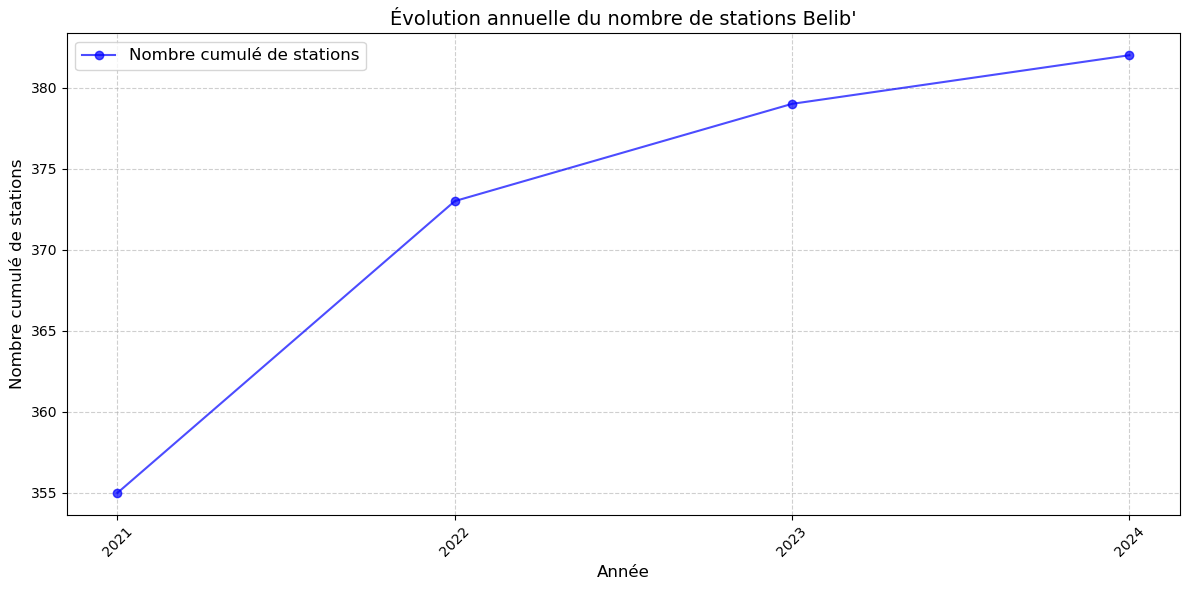

In [12]:
import matplotlib.pyplot as plt

def plot_evolution(data, column, title, xlabel, ylabel, color='blue', marker='o', label=None):
    """
    Fonction pour tracer un graphique d'évolution annuelle basé sur des données données.

    Arguments:
    data : DataFrame
        Un DataFrame Pandas contenant les données à tracer.
    column : str
        Le nom de la colonne à tracer.
    title : str
        Le titre du graphique.
    xlabel : str
        Le label de l'axe des abscisses.
    ylabel : str
        Le label de l'axe des ordonnées.VariationVaitVVVVVSVGvVVVVASIY
    color : str, optionnel
        Couleur de la ligne du graphique. Par défaut, 'blue'.
    marker : str, optionnel
        Style du marqueur pour les points de données. Par défaut, 'o'.
    label : str, optionnel
        Label pour la légende. Par défaut, None.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(
        data.index,
        data[column],
        marker=marker,
        color=color,
        label=label if label else column,
        alpha=0.7
    )
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(data.index, data.index.astype(int), rotation=45)
    if label:
        plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


# Graphique pour le nombre cumulé de stations
plot_evolution(
    data=df_static_grouped_year,
    column='cumulative_stations',
    title="Évolution annuelle du nombre de stations Belib'",
    xlabel="Année",
    ylabel="Nombre cumulé de stations",
    color='blue',
    marker='o',
    label='Nombre cumulé de stations'
)



Disponibilité en temps réél des bornes de recharges

In [ ]:
# Graphique pour le nombre cumulé de PDC
# Correction nous devons  faire des corrections 
plot_evolution(
    data=data_grouped_year,
    column='cumulative_pdc',
    title="Évolution annuelle du nombre de points de recharge (PDC) Belib'",
    xlabel="Année",
    ylabel="Nombre cumulé de PDC",
    color='orange',
    marker='o',
    label='Nombre cumulé de PDC'
)